In [3]:
# !pip install wordcloud

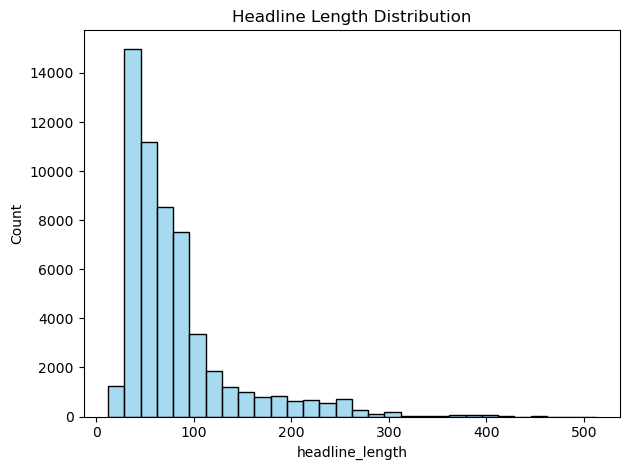

C:\Users\Hp victus\AppData\Local\Temp\ipykernel_22056\2174577440.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")


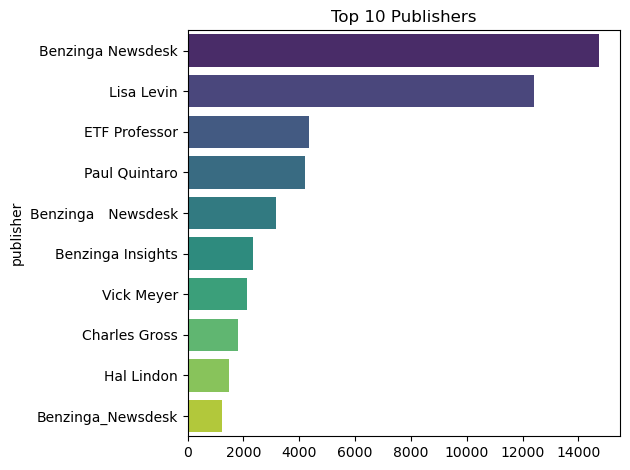

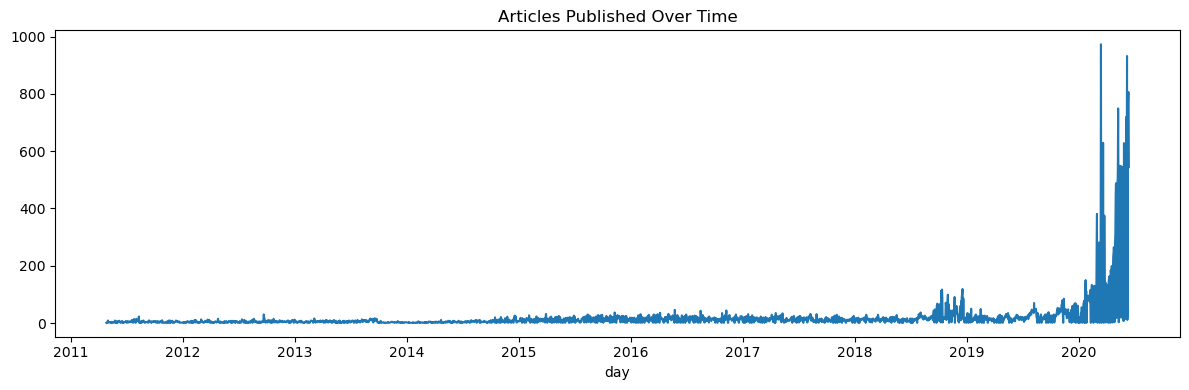

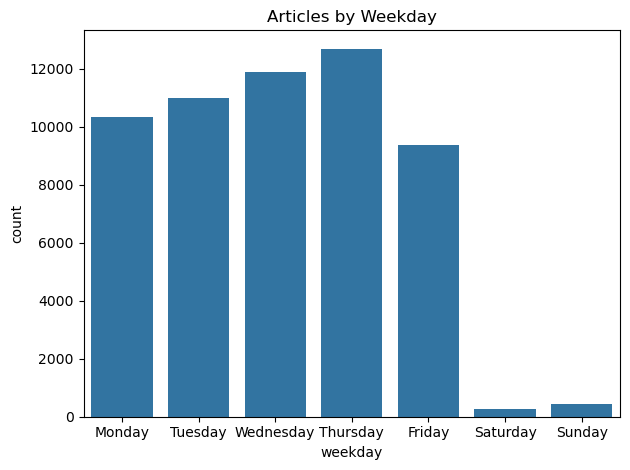

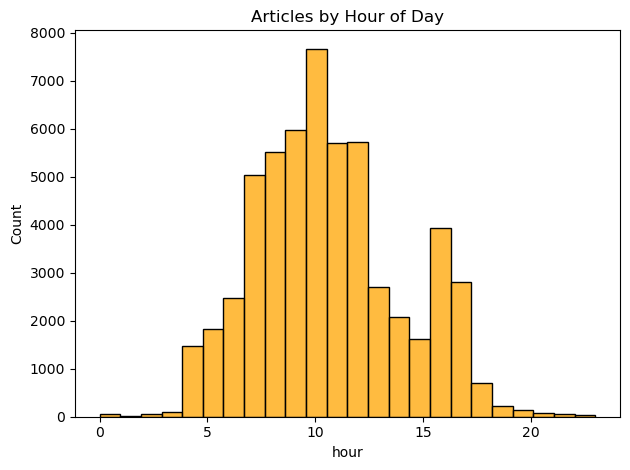


Top Keywords: ['52', 'companies', 'eps', 'estimate', 'higher', 'hit', 'lows', 'maintains', 'market', 'new', 'price', 'q1', 'sales', 'session', 'shares', 'stocks', 'target', 'trading', 'week', 'yesterday']


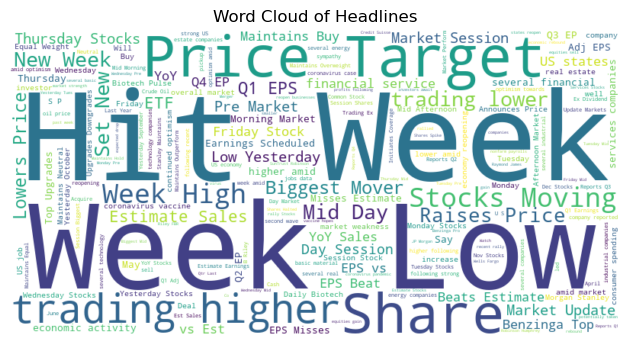


Top publisher domains:
 domain
benzinga.com    1196
gmail.com          3
Name: count, dtype: int64

✅ All EDA plots saved in 'output/eda'


In [12]:
"""
NewsAnalyzer: A class to perform EDA on financial news headlines
Task 1 - 10 Academy AIM Week 1 Challenge

"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from typing import Optional


class NewsAnalyzer:
    def __init__(self, csv_path: str, output_dir: str = "output/eda", show_plots: bool = False):
        """
        Initialize the analyzer with path to dataset.

        Args:
            csv_path (str): Path to CSV containing financial news
            output_dir (str): Folder to store generated visualizations
            show_plots (bool): Whether to display plots inline (for Jupyter use)
        """
        self.csv_path = csv_path
        self.output_dir = output_dir
        self.show_plots = show_plots
        os.makedirs(self.output_dir, exist_ok=True)
        self.df: Optional[pd.DataFrame] = None

    def load_and_prepare(self) -> None:
        """Load and preprocess the dataset."""
        self.df = pd.read_csv(self.csv_path)
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
        self.df.dropna(subset=['headline', 'date'], inplace=True)
        self.df['headline'] = self.df['headline'].astype(str).str.strip()
        self.df['publisher'] = self.df['publisher'].astype(str).str.strip()
        self.df['headline_length'] = self.df['headline'].apply(len)
        self.df['day'] = self.df['date'].dt.date
        self.df['weekday'] = self.df['date'].dt.day_name()
        self.df['hour'] = self.df['date'].dt.hour
        self.df['domain'] = self.df['publisher'].str.extract(r'@([\w\.-]+)')

    def generate_descriptive_stats(self) -> None:
        """Generate and save plots for headline length and publisher activity."""
        sns.histplot(self.df['headline_length'], bins=30, color='skyblue')
        plt.title("Headline Length Distribution")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/headline_length_dist.png")
        if self.show_plots:
            plt.show()
        plt.close()

        top_publishers = self.df['publisher'].value_counts().head(10)
        sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")
        plt.title("Top 10 Publishers")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/top_publishers.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def analyze_publication_trends(self) -> None:
        """Analyze article trends by date, weekday, and hour."""
        self.df.groupby('day').size().plot(figsize=(12, 4))
        plt.title("Articles Published Over Time")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_over_time.png")
        if self.show_plots:
            plt.show()
        plt.close()

        sns.countplot(x='weekday', data=self.df,
                      order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        plt.title("Articles by Weekday")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_by_weekday.png")
        if self.show_plots:
            plt.show()
        plt.close()

        sns.histplot(self.df['hour'].dropna(), bins=24, color='orange')
        plt.title("Articles by Hour of Day")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_by_hour.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def extract_topics(self) -> None:
        """Use basic NLP to extract keywords and generate word cloud."""
        vectorizer = CountVectorizer(max_features=20, stop_words='english')
        X = vectorizer.fit_transform(self.df['headline'])
        keywords = vectorizer.get_feature_names_out()
        print("\nTop Keywords:", list(keywords))

        text = " ".join(self.df['headline'].tolist())
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud of Headlines")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/wordcloud.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def analyze_domains(self) -> None:
        """Check for email-like publisher domains."""
        domain_counts = self.df['domain'].value_counts().dropna().head(5)
        if not domain_counts.empty:
            print("\nTop publisher domains:\n", domain_counts)
        else:
            print("\nNo valid publisher domains found.")

    def run_all(self) -> None:
        """Run all EDA steps."""
        self.load_and_prepare()
        self.generate_descriptive_stats()
        self.analyze_publication_trends()
        self.extract_topics()
        self.analyze_domains()
        print(f"\n✅ All EDA plots saved in '{self.output_dir}'")


# Example usage
if __name__ == "__main__":
    # For script mode (no plot display)
    analyzer = NewsAnalyzer(csv_path="../data/raw_analyst_ratings.csv", show_plots=True)
    analyzer.run_all()

In [11]:
from src.news_analyzer import NewsAnalyzer

analyzer = NewsAnalyzer(csv_path="../data/financial_news.csv", show_plots=True)
analyzer.run_all()


ModuleNotFoundError: No module named 'src'